In [3]:
!pip uninstall -y numpy pmdarima
!pip install numpy==1.26.0
!pip install pmdarima==2.0.4

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 87.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.0 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.0 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.0 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.0 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.0 which is incompatible.
pytensor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.1 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

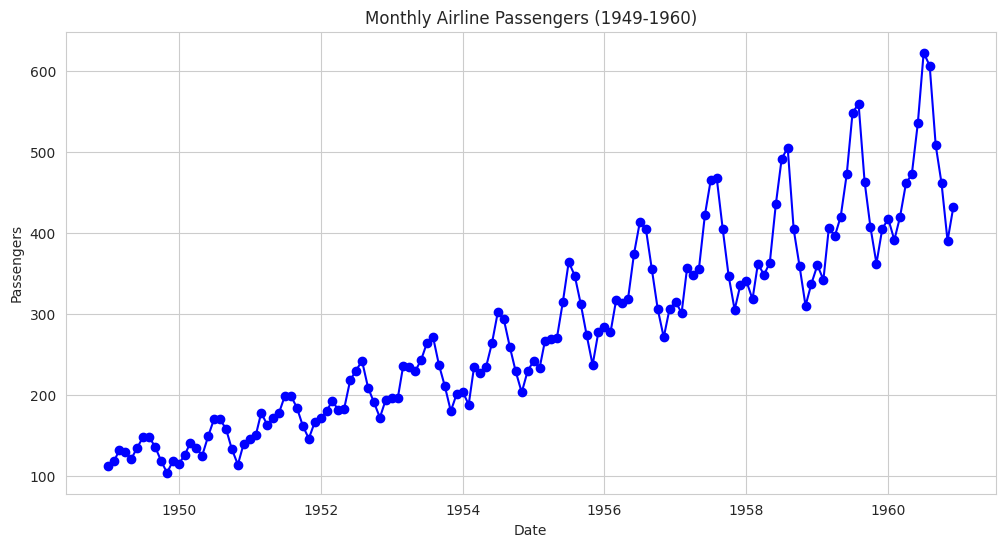

In [3]:
from statsmodels.datasets import get_rdataset
data = get_rdataset("AirPassengers").data

dates = pd.date_range(start='1949-01', periods=len(data), freq='MS')
data['Month'] = dates
data.set_index('Month', inplace=True)
ts = data['value']

plt.figure(figsize=(12,6))
plt.plot(ts, marker='o', color='blue')
plt.title("Monthly Airline Passengers (1949-1960)")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.show()

This dataset contains monthly totals of international airline passengers from 1949 to 1960.  
We visualize the data to see trends and seasonality.

## Seasonal decomposition

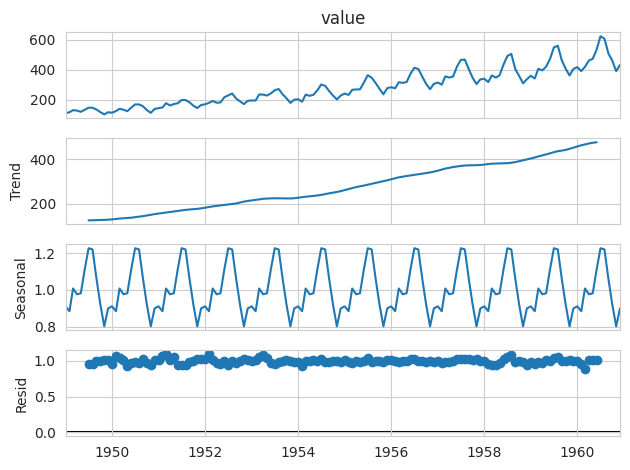

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(ts, model='multiplicative', period=12)
decomp.plot()
plt.show()

Decompose the series into trend, seasonal, and residual components.  
Helps visualize seasonality and trend patterns for ARIMA modeling.

# Stationarity Check

Original Series:
ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641
Non-stationary

First Difference Series:
ADF Statistic: -2.717130598388114
p-value: 0.07112054815086184
Non-stationary


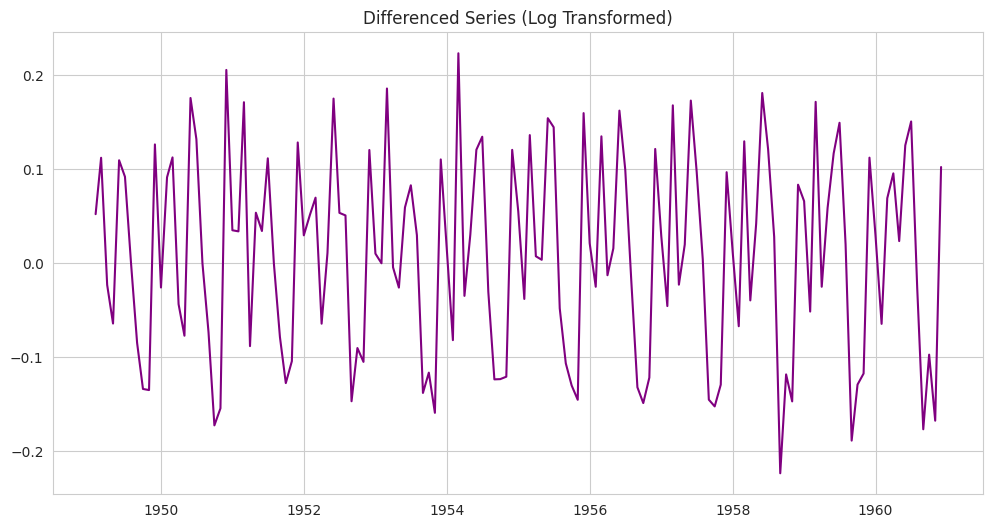

In [5]:
def test_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("Stationary")
    else:
        print("Non-stationary")

print("Original Series:")
test_stationarity(ts)

ts_log = np.log(ts)
ts_log_diff = ts_log.diff().dropna()
print("\nFirst Difference Series:")
test_stationarity(ts_log_diff)

plt.figure(figsize=(12,6))
plt.plot(ts_log_diff, color='purple')
plt.title("Differenced Series (Log Transformed)")
plt.show()


ARIMA requires stationary data.  
We check stationarity using the ADF test and apply log transformation + differencing if necessary.

# ACF and PACF plots

<Figure size 1200x400 with 0 Axes>

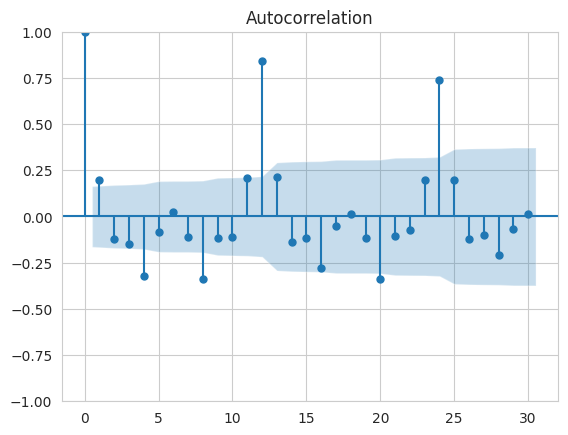

<Figure size 1200x400 with 0 Axes>

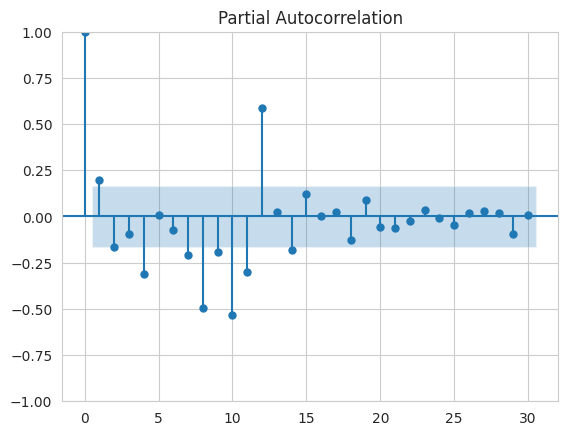

In [6]:
plt.figure(figsize=(12,4))
plot_acf(ts_log_diff, lags=30)
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(ts_log_diff, lags=30, method='ywm')
plt.show()

ACF and PACF plots help identify appropriate AR (p) and MA (q) terms for ARIMA.

# Auto ARIMA for parameters
A library that helps you decide parameters for ARIMA

In [7]:
model_auto = auto_arima(ts_log, seasonal=True, m=12, stepwise=True, trace=True)
print(model_auto.summary())

p, d, q = model_auto.order
P, D, Q, m = model_auto.seasonal_order
print(f"ARIMA order: {(p,d,q)}")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-483.493, Time=6.72 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-358.005, Time=0.14 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-472.836, Time=3.01 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-423.080, Time=1.46 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-152.756, Time=0.07 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-485.488, Time=8.65 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-455.363, Time=3.66 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-483.597, Time=8.99 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-479.075, Time=1.94 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=-483.251, Time=5.42 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-486.999, Time=2.17 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-455.568, Time=2.32 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-477.993, Time=2.54 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-484.698, Time=3.92 sec
 ARIMA(1,0,2)(1,1,0

# Fit SARIMA

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [10]:
model = SARIMAX(ts_log, order=(p,d,q), seasonal_order=(P,D,Q,m))
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                value   No. Observations:                  144
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 244.709
Date:                              Fri, 24 Oct 2025   AIC                           -481.419
Time:                                      18:44:07   BIC                           -469.888
Sample:                                  01-01-1949   HQIC                          -476.733
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6547      0.069      9.526      0.000       0.520       0.789
ar.L2          0.33

# Residual Analysis

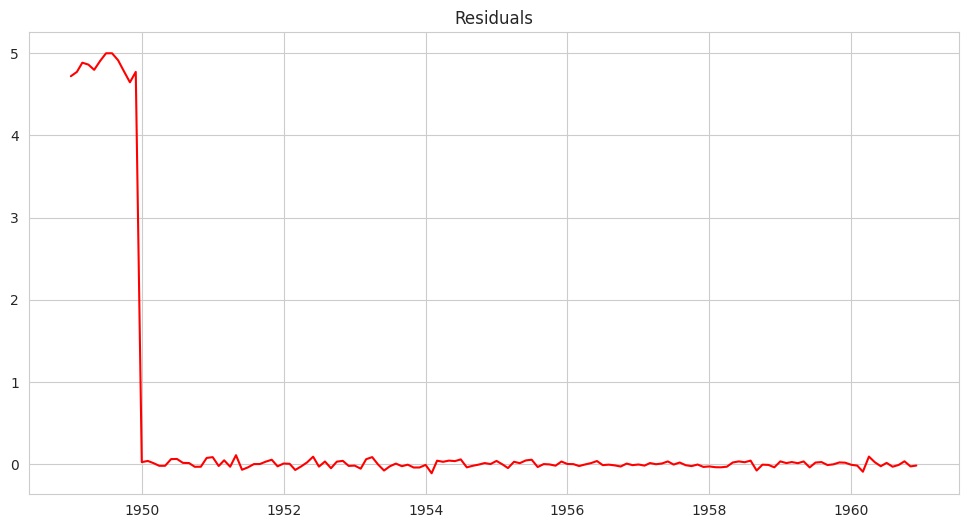

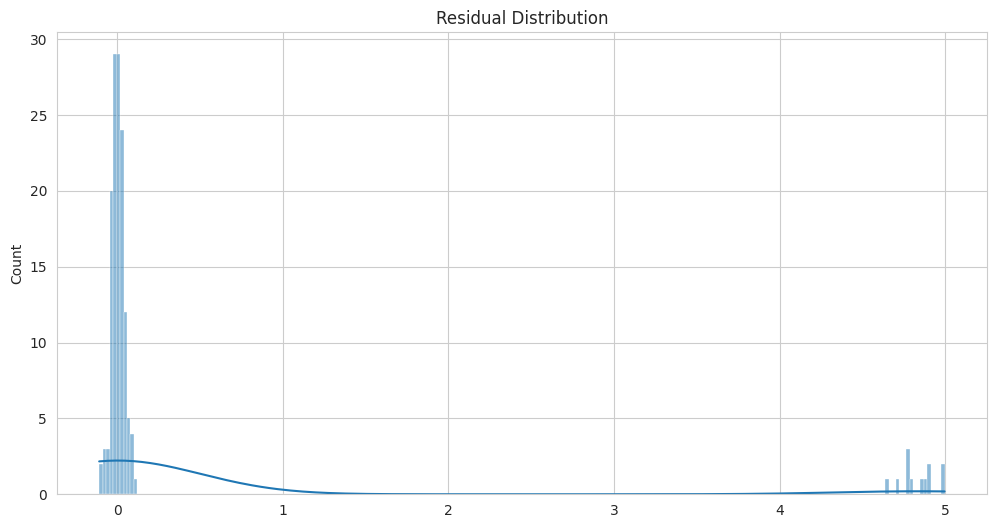

<Figure size 1200x400 with 0 Axes>

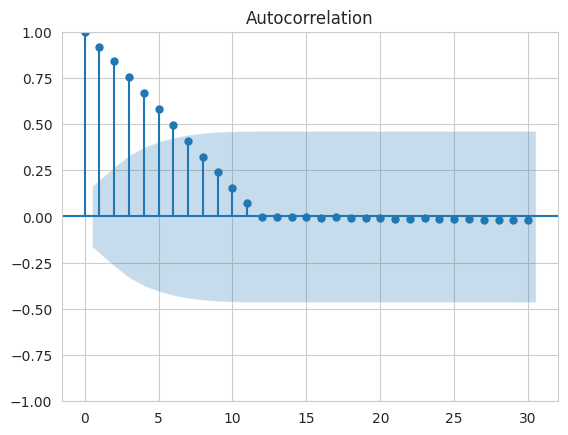

In [11]:
residuals = model_fit.resid
plt.figure(figsize=(12,6))
plt.plot(residuals, color='red')
plt.title("Residuals")
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

plt.figure(figsize=(12,4))
plot_acf(residuals, lags=30)
plt.show()

# Forecasting next 36 months

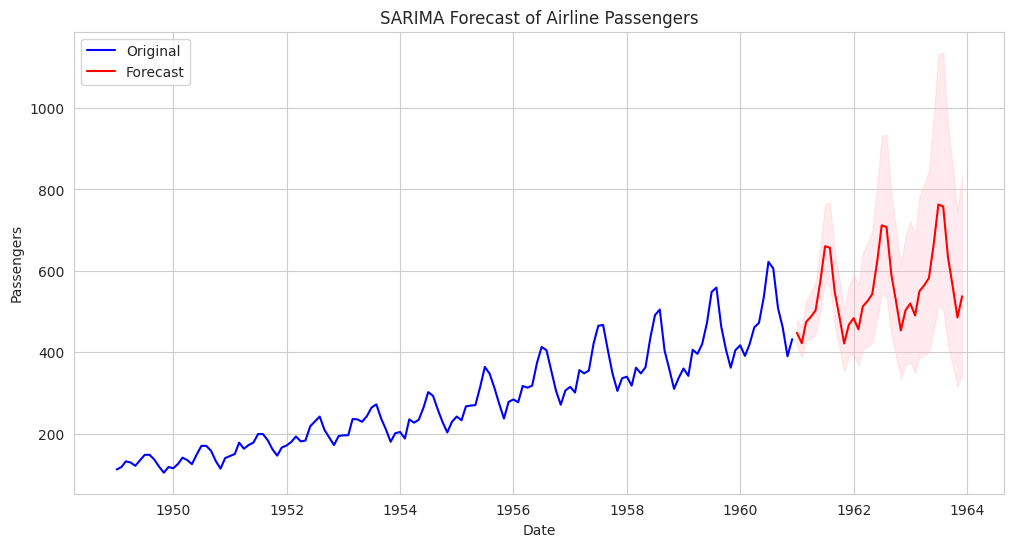

In [12]:
forecast_steps = 36
forecast_result = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = np.exp(forecast_result.predicted_mean)
conf_int = np.exp(forecast_result.conf_int())

plt.figure(figsize=(12,6))
plt.plot(ts, label='Original', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.title("SARIMA Forecast of Airline Passengers")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()

# Model Training

In [13]:
train = ts_log.iloc[:-36]
test = ts_log.iloc[-36:]

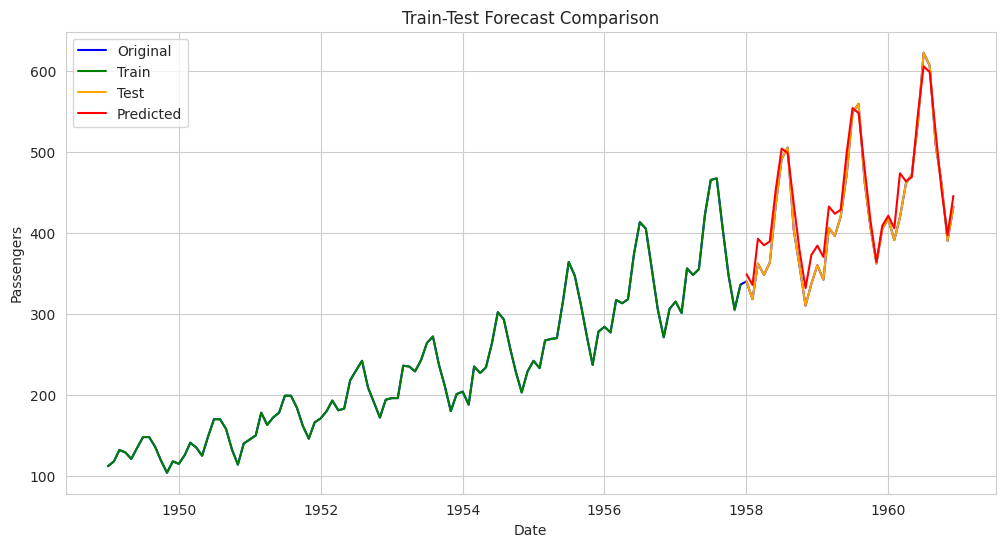

In [14]:
model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,m))
model_fit = model.fit()
pred_log = model_fit.forecast(steps=len(test))
pred = np.exp(pred_log)

plt.figure(figsize=(12,6))
plt.plot(ts, label='Original', color='blue')
plt.plot(np.exp(train), label='Train', color='green')
plt.plot(np.exp(test), label='Test', color='orange')
plt.plot(pred.index, pred, color='red', label='Predicted')
plt.title("Train-Test Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()

In [15]:
mae = mean_absolute_error(np.exp(test), pred)
mse = mean_squared_error(np.exp(test), pred)
rmse = np.sqrt(mse)
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

MAE: 17.00, MSE: 425.95, RMSE: 20.64
